In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are, inv

In [2]:
def integrator_rk4(f, x, u, p, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u, p)
        k2 = f(x + delta_t / 2 * k1, u, p)
        k3 = f(x + delta_t / 2 * k2, u, p)
        k4 = f(x + delta_t * k3, u, p)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next

### Test1

$\dot{x}_{1}=x_{2}, \quad \dot{x}_{2}=-\frac{k_{2}}{m} x_{1}^{3}-\frac{k_{1}}{m} x_{2}+\frac{1}{m} u+\theta_{1}$

In [3]:
def academic_model(x, u, p):
    m = 2  # [kg]
    k1 = 3  # [N/m]
    k2 = 2  # [N/m]

    #     A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
    #     B = ca.DM([[0], [1 / m]])

    x1p = x[1]
    x2p = -k2 / m * x[0] ** 3 - k1 / m * x[1] + 1 / m * u[0] + p

    rhs = [x1p,
           x2p
           ]

    return ca.vertcat(*rhs)

In [4]:
Nx = 2
Nu = 1
N_theta = 1 

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
theta_SX = ca.SX.sym("theta_SX", N_theta)
t_SX = ca.SX.sym("t", 1)

delta_t = 0.1

ode = ca.Function("ode_func", [x_SX, u_SX, theta_SX], [academic_model(x_SX, u_SX, theta_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, theta_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX], [ode_dis_SX])

In [5]:
N_sim = 30
N_traj = 500
x_init = [0,0]

theta_dist = 1

uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

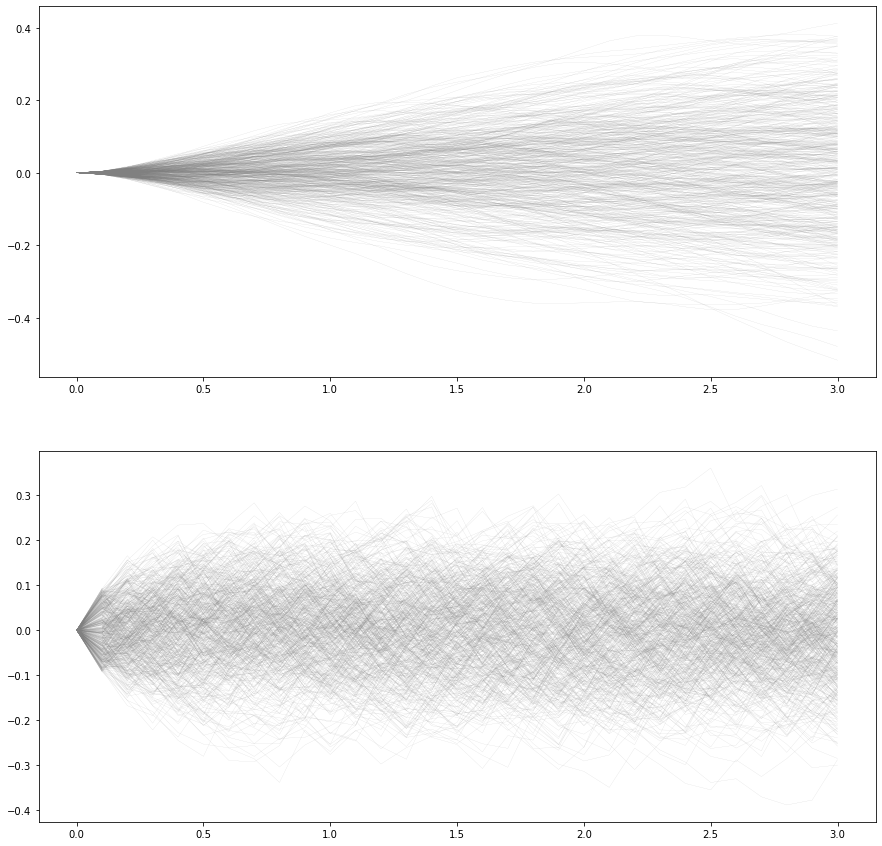

In [6]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

### test2 CSTR model

System comes from: Nonlinear CSTR control system design using an artificial bee
colony algorithm

$\dot{x}_{1}=-x_{1}+D_{a}\left(1-x_{1}\right) \exp \left(\frac{x_{2}}{1+x_{2} / \varphi}\right)$

$\dot{x}_{2}=-(1+\delta) x_{2}+B \cdot D_{a}\left(1-x_{2}\right) \exp \left(\frac{x_{2}}{1+x_{2} / \varphi}\right)+\delta \cdot u$

with $D_{a}=0.072, \varphi=20, B=8$ and $\delta=0.3$

and for $u=0$, equilibrium points, $\left(x_{1}, x_{2}\right)=(0.144,0.886)_{s \cdot}\left(x_{1}, x_{2}\right)=(0.445,2.74)_{u}$, and $\left(x_{1}, x_{2}\right)=(0.765,4.705)_{s}$,

In [7]:
def CSTR(x, u, p):
    Da = 0.072
    phi = 20
    B = 8
    delta = 0.3
    
    
    x1p = -x[0] + Da * (1 - x[0]) * ca.exp(x[1] / (1 + x[1]/phi))
    x2p = -(1 + delta) * x[1] + B* Da * (1 - x[0]) * ca.exp(x[1] / (1 + x[1]/phi)) + delta * u + p
    
    rhs = [x1p,
           x2p
           ]

    return ca.vertcat(*rhs)

In [8]:
Nx = 2
Nu = 1
N_theta = 1 

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
theta_SX = ca.SX.sym("theta_SX", N_theta)
t_SX = ca.SX.sym("t", 1)

delta_t = 0.1

ode = ca.Function("ode_func", [x_SX, u_SX, theta_SX], [CSTR(x_SX, u_SX, theta_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, theta_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX], [ode_dis_SX])

In [9]:
ode([0.144,0.886],0,0)

DM([-3.12269e-05, -4.98153e-05])

#### init = [0,0]

In [10]:
N_sim = 1000
N_traj = 500
x_init = [0.3,0.5]
theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

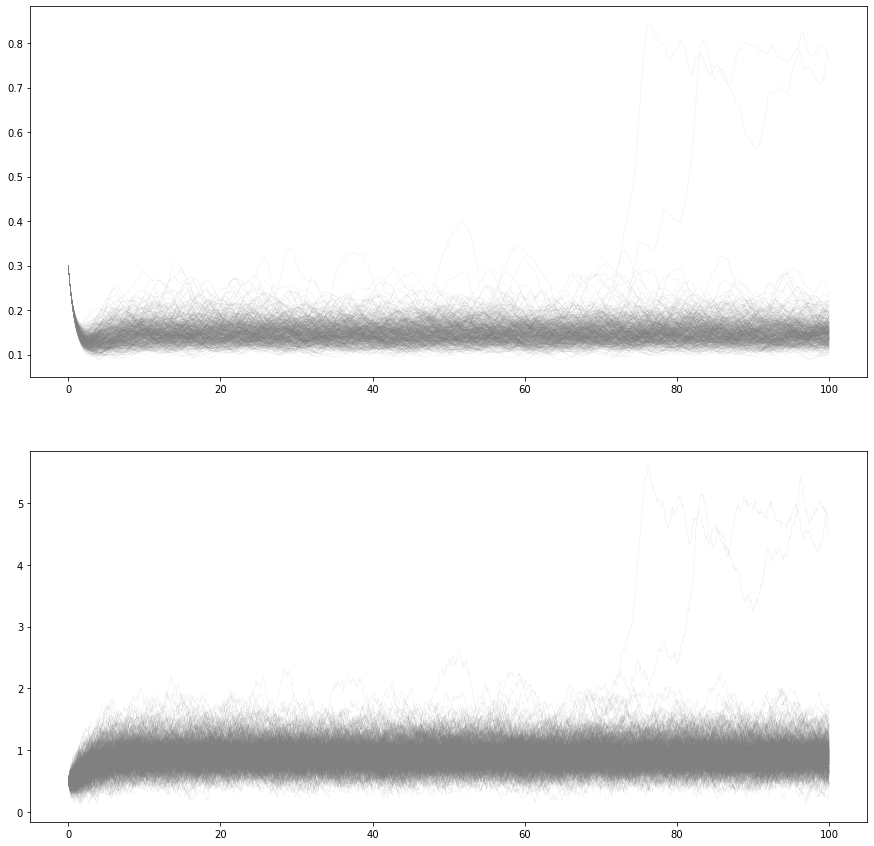

In [11]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.5,3]

In [12]:
N_sim = 1000
N_traj = 500
x_init = [0.5,3.]
theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

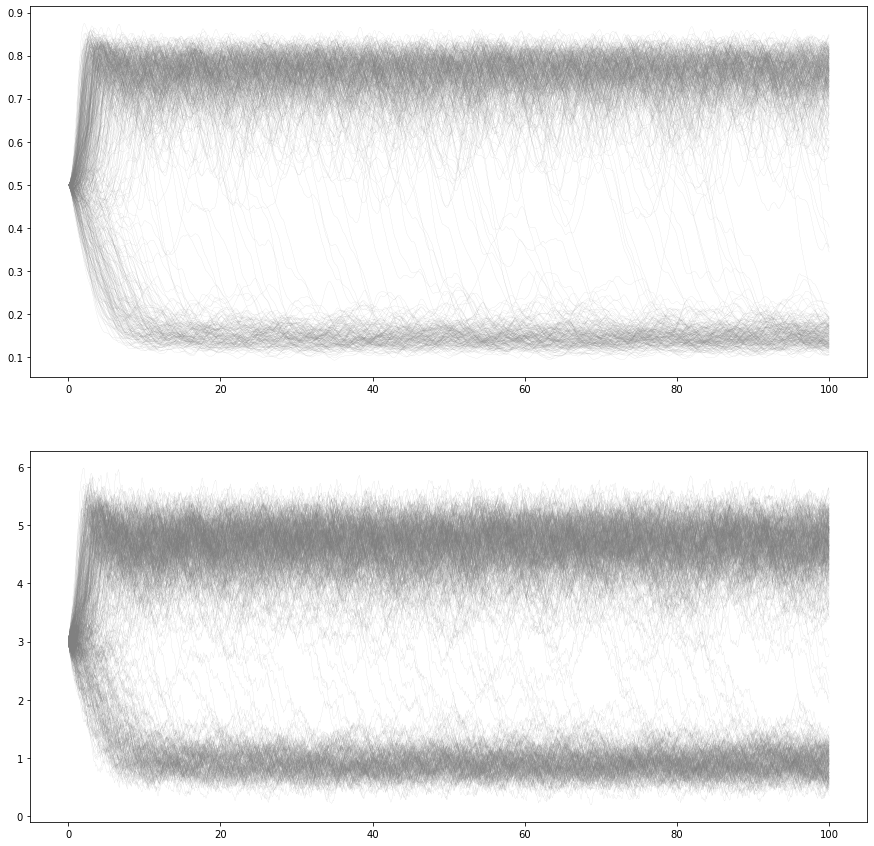

In [13]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.7,5.]

In [14]:
N_sim = 1000
N_traj = 500
x_init = [0.7,5.]
theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1
    traj_list += [traj_temp_list]

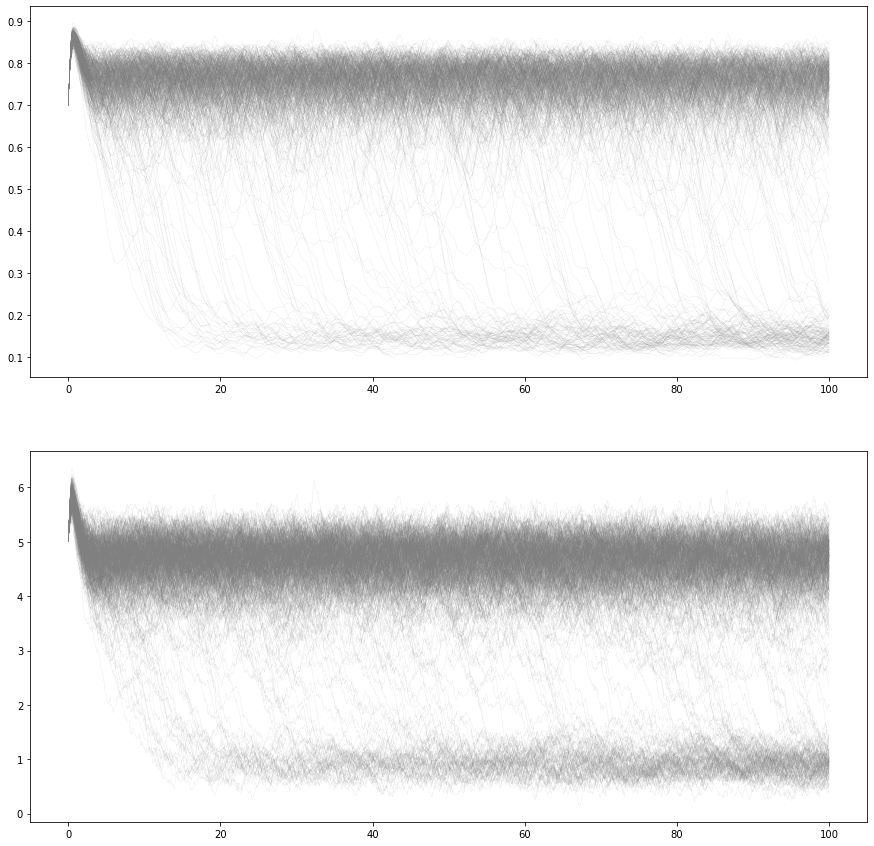

In [15]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

Effect with Linear controller: LQR

In [21]:
def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    P = np.matrix(solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(inv(B.T*P*B+R)*(B.T*P*A))
    return -K

In [17]:
dt_sys = ode_dis_func(x_SX, u_SX, 0)
A = ca.jacobian(dt_sys, x_SX)
B = ca.jacobian(dt_sys, u_SX)

A_fn = ca.Function("A_fn", [x_SX, u_SX], [A])
B_fn = ca.Function("B_fn", [x_SX, u_SX], [B])

### Test static feedback derived at (0.144,0.886) from LQR

In [18]:
Q = np.diag([1,1])
R = np.diag([1])

xk = [0.144,0.886]
uk = [0]

A_np = A_fn(xk,uk).full()
B_np = B_fn(xk,uk).full()

K_np = np.array(dlqr(A_np,B_np,Q,R))

#### init = [0,0]

In [19]:
N_sim = 1000
N_traj = 500
x_init = [0.,0.]

xr = np.array([[0.144],[0.886]])

theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        uk = K_np @ (xk - xr)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]

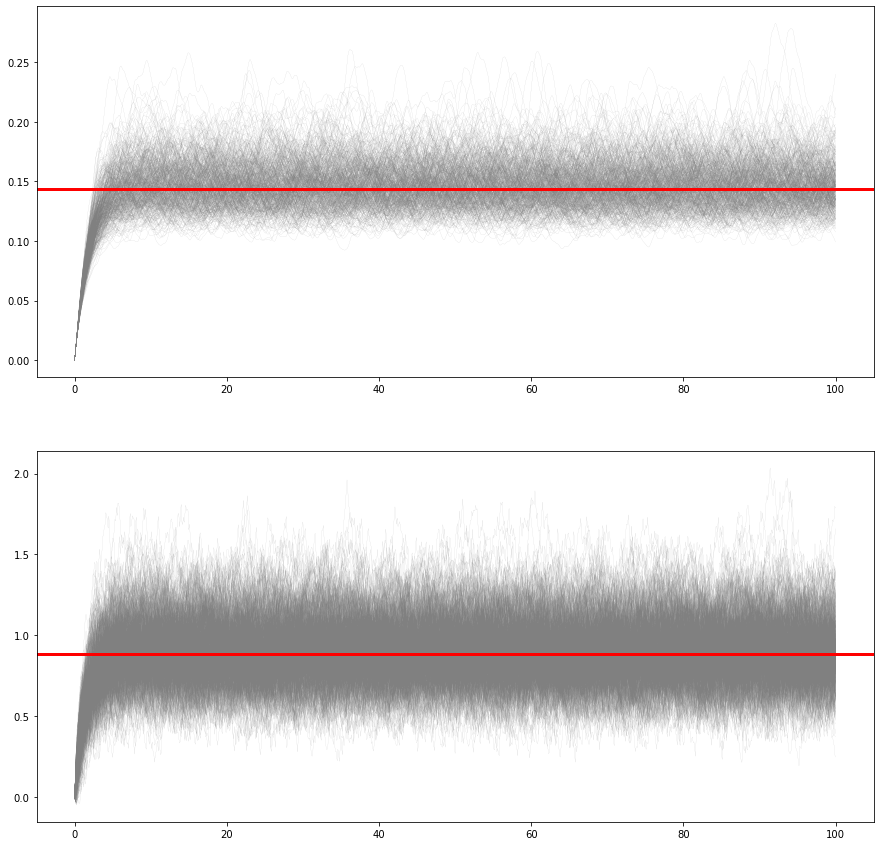

In [20]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.5,3]

In [21]:
N_sim = 1000
N_traj = 500
x_init = [0.5,3.]

xr = np.array([[0.144],[0.886]])

theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        uk = K_np @ (xk - xr)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]

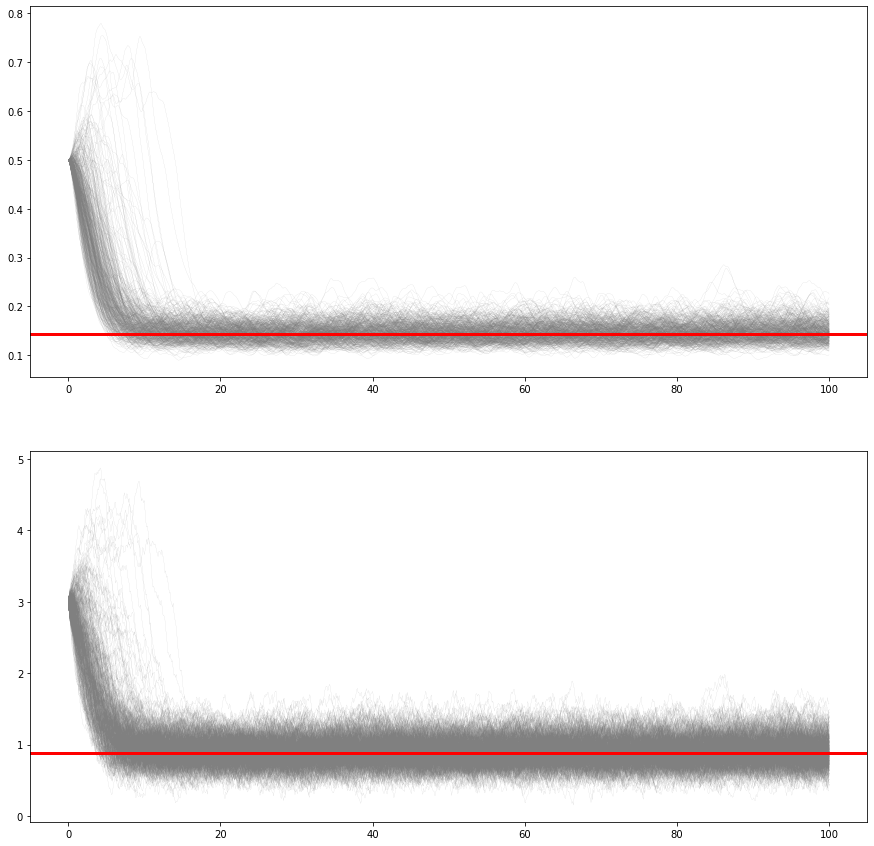

In [22]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.7,5.]

In [23]:
N_sim = 1000
N_traj = 500
x_init = [0.7,5.]

xr = np.array([[0.144],[0.886]])

theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        uk = K_np @ (xk - xr)
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]

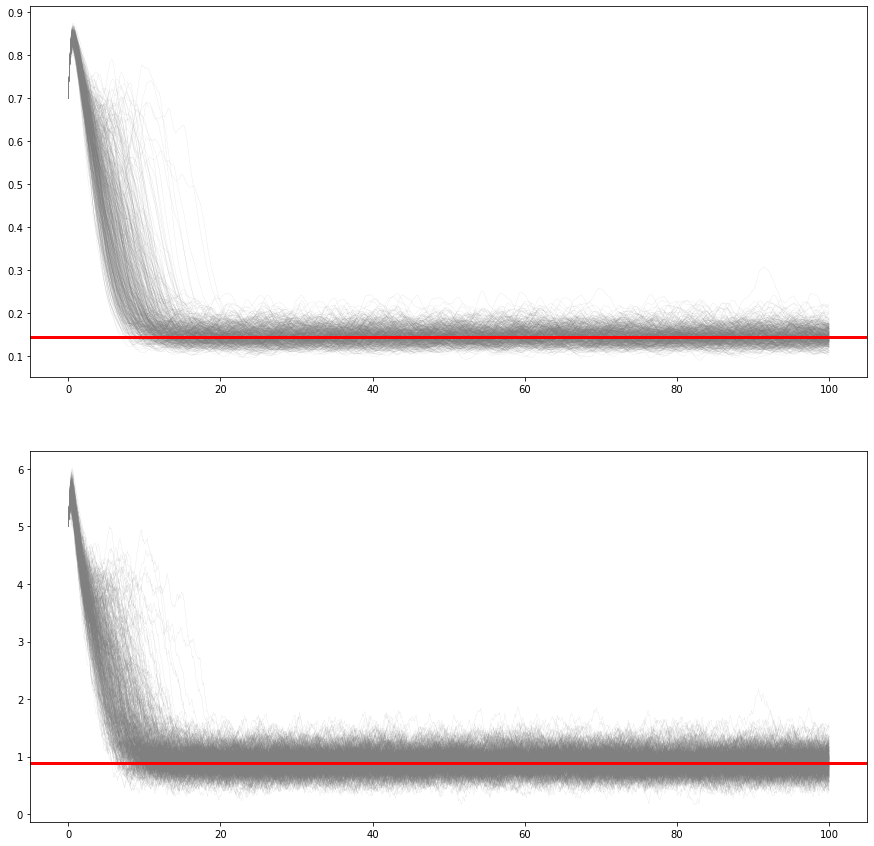

In [24]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

### Try time-varying feedback gain

#### init = [0, 0]

In [25]:
N_sim = 1000
N_traj = 200
x_init = [0.,0.]

xr = np.array([[0.144],[0.886]])

theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    uk_p = np.array([[0]])
    for j in range(N_sim):
        A_np = A_fn(xk,uk_p).full()
        B_np = B_fn(xk,uk_p).full()
        
        K_np = np.array(dlqr(A_np,B_np,Q,R))
        
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        uk = K_np @ (xk - xr)
        uk_p = uk
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]
    print('{number} is done'.format(number = i))

0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
35 is done
36 is done
37 is done
38 is done
39 is done
40 is done
41 is done
42 is done
43 is done
44 is done
45 is done
46 is done
47 is done
48 is done
49 is done
50 is done
51 is done
52 is done
53 is done
54 is done
55 is done
56 is done
57 is done
58 is done
59 is done
60 is done
61 is done
62 is done
63 is done
64 is done
65 is done
66 is done
67 is done
68 is done
69 is done
70 is done
71 is done
72 is done
73 is done
74 is done
75 is done
76 is done
77 is done
78 is done
79 is done
80 is done
81 is done
82 is done
83 is done
84 is done
85 is done
86 is done
87 is done
88 is done
89 is done
90 is done
91 is don

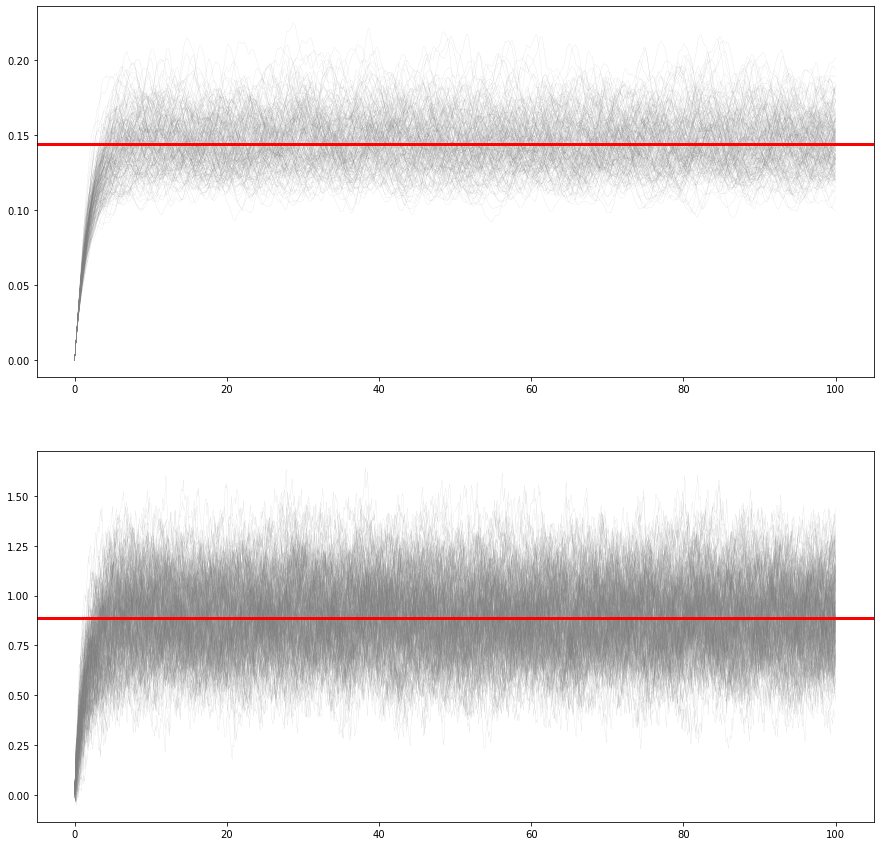

In [26]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.5,3]

In [27]:
N_sim = 1000
N_traj = 200
x_init = [0.5,3.]

xr = np.array([[0.144],[0.886]])

theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    uk_p = np.array([[0]])
    for j in range(N_sim):
        A_np = A_fn(xk,uk_p).full()
        B_np = B_fn(xk,uk_p).full()
        
        K_np = np.array(dlqr(A_np,B_np,Q,R))
        
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        uk = K_np @ (xk - xr)
        uk_p = uk
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]
    print('{number} is done'.format(number = i))

0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
35 is done
36 is done
37 is done
38 is done
39 is done
40 is done
41 is done
42 is done
43 is done
44 is done
45 is done
46 is done
47 is done
48 is done
49 is done
50 is done
51 is done
52 is done
53 is done
54 is done
55 is done
56 is done
57 is done
58 is done
59 is done
60 is done
61 is done
62 is done
63 is done
64 is done
65 is done
66 is done
67 is done
68 is done
69 is done
70 is done
71 is done
72 is done
73 is done
74 is done
75 is done
76 is done
77 is done
78 is done
79 is done
80 is done
81 is done
82 is done
83 is done
84 is done
85 is done
86 is done
87 is done
88 is done
89 is done
90 is done
91 is don

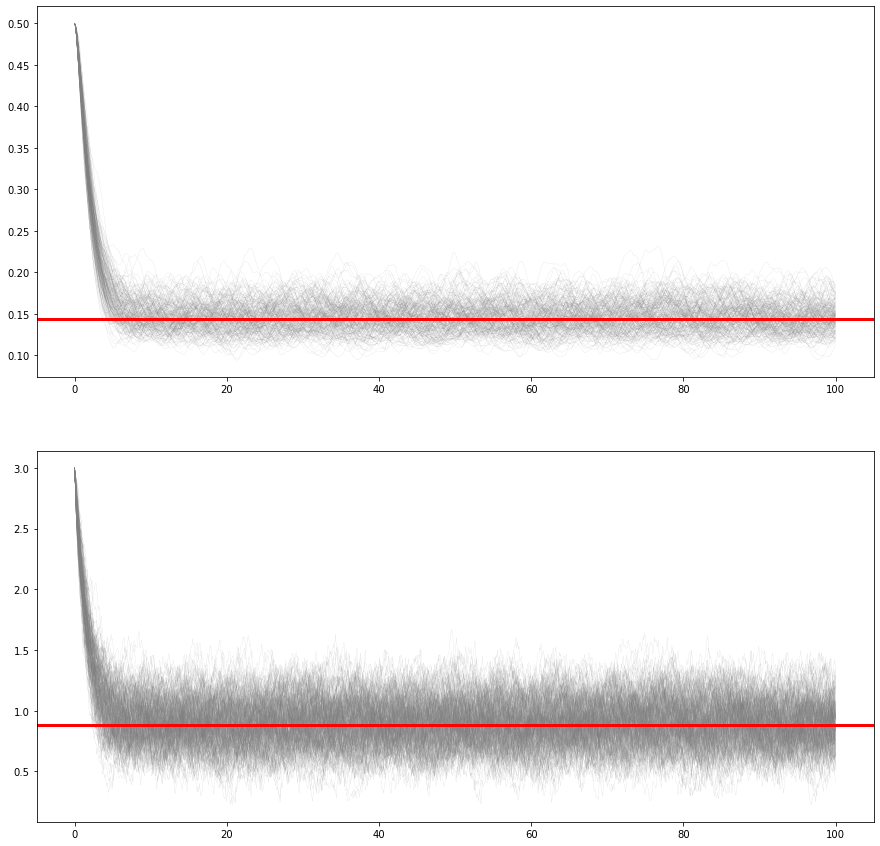

In [28]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
# ax2.plot(tgrid, x2_mean, 'r', lw=3)
plt.show()

#### init = [0.7,5.]

In [29]:
N_sim = 1000
N_traj = 200
x_init = [0.7,5.]

xr = np.array([[0.144],[0.886]])

theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    uk_p = np.array([[0]])
    for j in range(N_sim):
        A_np = A_fn(xk,uk_p).full()
        B_np = B_fn(xk,uk_p).full()
        
        K_np = np.array(dlqr(A_np,B_np,Q,R))
        
        theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        uk = K_np @ (xk - xr)
        uk_p = uk
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]
    print('{number} is done'.format(number = i))

0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
35 is done
36 is done
37 is done
38 is done
39 is done
40 is done
41 is done
42 is done
43 is done
44 is done
45 is done
46 is done
47 is done
48 is done
49 is done
50 is done
51 is done
52 is done
53 is done
54 is done
55 is done
56 is done
57 is done
58 is done
59 is done
60 is done
61 is done
62 is done
63 is done
64 is done
65 is done
66 is done
67 is done
68 is done
69 is done
70 is done
71 is done
72 is done
73 is done
74 is done
75 is done
76 is done
77 is done
78 is done
79 is done
80 is done
81 is done
82 is done
83 is done
84 is done
85 is done
86 is done
87 is done
88 is done
89 is done
90 is done
91 is don

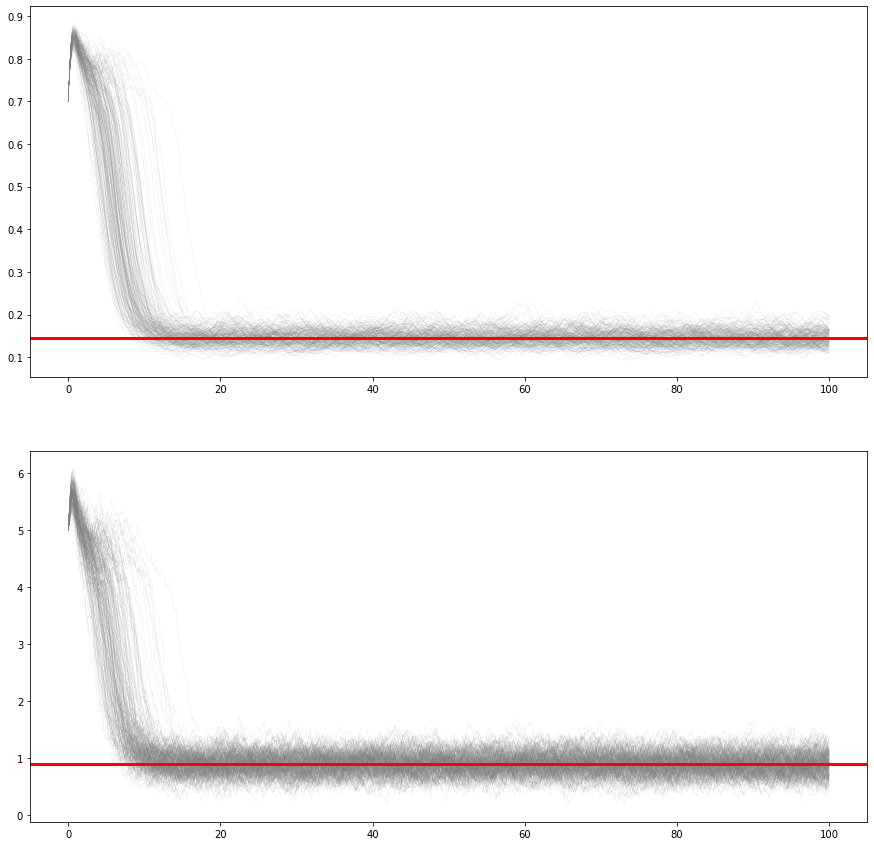

In [30]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax1.plot(tgrid, xr[0], 'r', lw=3)            
# ax2.plot(tgrid, xr[1], 'r', lw=3)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
plt.show()

### CSTR version 2

ref: NONLINEAR PREDICTIVE CONTROL OF A BENCHMARK CSTR


$\begin{aligned} \dot{c}_{A}=& \frac{\dot{V}}{V_{R}}\left(c_{A 0}-c_{A}\right)-k_{1}(\vartheta) c_{A}-k_{3}(\vartheta) c_{A}^{2} \\ \dot{c}_{B}=&-\frac{\dot{V}}{V_{R}} c_{B}+k_{1}(\vartheta) c_{A}-k_{2}(\vartheta) c_{B} \\ \dot{\vartheta}=& \frac{\dot{V}}{V_{R}}\left(\vartheta_{0}-\vartheta\right)-\frac{1}{\rho C_{p}}\left(k_{1}(\vartheta) c_{A} \Delta H_{R_{A B}}\right.\\ &\left.+k_{2}(\vartheta) c_{B} \Delta H_{R_{B C}}+k_{3}(\vartheta) c_{A}^{2} \Delta H_{R_{A D}}\right) \\ &+\frac{k_{w} A_{R}}{\rho C_{p} V_{R}}\left(\vartheta_{K}-\vartheta\right) \\ \dot{\vartheta}_{K}=& \frac{1}{m_{K} C_{P K}}\left(\dot{Q}_{K}+k_{w} A_{R}\left(\vartheta-\vartheta_{K}\right)\right) \quad c_{A} \geq 0, c_{B} \geq 0 . \end{aligned}$

Parameters:

$$
\begin{array}{|c|c|c|}
\hline \text { Name of parameter } & \text { Symbol } & \text { Value of parameter } \\
\hline \text { collision factor for reaction } k_{1} & k_{10} & (1.287 \pm 0.04) \cdot 10^{12} \mathrm{~h}^{-1} \\
\text { collision factor for reaction } k_{2} & k_{20} & (1.287 \pm 0.04) \cdot 10^{12} \mathrm{~h}^{-1} \\
\text { collision factor for reaction } k_{3} & k_{30} & (9.043 \pm 0.27) \cdot 10^{9} \frac{1}{\mathrm{~mol} A \cdot h} \\
\text { activation energy for reaction } k_{1} & E_{1} & -9758.3 \mathrm{~K} \\
\text { activation energy for reaction } k_{2} & E_{2} & -9758.3 \mathrm{~K} \\
\text { activation energy for reaction } k_{3} & E_{3} & -8560 \mathrm{~K} \\
\text { enthalpies of reaction } k_{1} & \Delta H_{R_{A B}} & (4.2 \pm 2.36) \frac{\mathrm{kJ}}{\mathrm{mol} \mathrm{}} \\
\text { enthalpies of reaction } k_{2} & \Delta H_{R_{B C}} & -(11.0 \pm 1.92) \frac{\mathrm{kJ}}{\mathrm{mol} B} \\
\text { enthalpies of reaction } k_{3} & \Delta H_{R_{A D}} & -(41.85 \pm 1.41) \frac{\mathrm{kJ}}{\mathrm{mol} \mathrm{A}} \\
\text { density } & \rho & \left(0.9342 \pm 4.0 \cdot 10^{-4}\right) \frac{\mathrm{kg}}{\mathrm{l}} \\
\text { heat capacity } & C_{p} & (3.01 \pm 0.04) \frac{\mathrm{kJ}}{\mathrm{kg} \cdot \mathrm{K}} \\
\text { heat transfer coefficient for cooling jacket } & k_{w} & (4032 \pm 120) \frac{\mathrm{kJ}}{\mathrm{h} \cdot \mathrm{m}^{2} \cdot \mathrm{K}} \\
\text { surface of cooling jacket } & A_{R} & 0.215 \mathrm{~m}{ }^{2} \\
\text { reactor volume } & V_{R} & 0.01 \mathrm{~m} \\
\text { coolant mass } & m_{K}^{3} & 5.0 \mathrm{~kg} \\
\text { heat capacity of coolant } & C_{P K} & (2.0 \pm 0.05) \frac{\mathrm{kJ}}{\mathrm{kg} \cdot \mathrm{K}} \\
\hline
\end{array}
$$

$$
\begin{aligned}
\left.c_{A 0}\right|_{S} &=5.10 \frac{\mathrm{mol}}{l} &\left.c_{A}\right|_{S} &=2.14 \frac{\mathrm{mol}}{l} \\
\left.\vartheta_{0}\right|_{S} &=104.9^{\circ} \mathrm{C} & &\left.c_{B}\right|_{S}=1.09 \frac{\mathrm{mol}}{l} \\
\left.\frac{\dot{V}}{V_{R}}\right|_{S} &=14.19 h^{-1} &\left.\vartheta\right|_{S} &=114.2^{\circ} \mathrm{C} \\
\left.\dot{Q}_{K}\right|_{S} &=-1113.5 \frac{\mathrm{kJ}}{\mathrm{h}} &\left.\vartheta_{K}\right|_{S} &=112.9^{\circ} \mathrm{C} .
\end{aligned}
$$

In [395]:
def CSTR_model2(x, u):
    '''
    state = [cA, cB, theta, theta_K]
    
    input = [V_dot/VR, QK_dot]
    
    ki(theta) = ki0 * exp(Ei / (theta + 273.15))
    '''
    
    k10 = 1.287e12
    k20 = 1.287e12
    k30 = 9.043e9
    
    E1 = -9758.3
    E2 = -9758.3
    E3 = -8560
    Delta_H_RAB = 4.2
    Delta_H_RBC = -11.0
    Delta_H_RAD = -41.85
    
    rho = 0.9342
    
    Cp = 3.01
    kw = 4032
    
    AR = 0.215
    VR = 0.01
    mK = 5.0
    CPK = 2.0
    
    cA0 = 5.10
    theta0 = 104.9
    
    
    cA = x[0]
    cB = x[1]
    theta = x[2]
    theta_K = x[3]
    
    k1 = k10 * ca.exp(E1 / (theta + 273.15))
    k2 = k20 * ca.exp(E2 / (theta + 273.15))
    k3 = k30 * ca.exp(E3 / (theta + 273.15))
    
    x1p = u[0] * (cA0 - cA) - k1 * cA - k3 * cA**2
    x2p = -u[0] * cB + k1 * cA - k2 * cB
    x3p = u[0] * (theta0 - theta) - 1/(rho * Cp) * (k1 * cA * Delta_H_RAB + k2 * cB * Delta_H_RBC + k3 * cA **2 * Delta_H_RAD) + (kw * AR) / (rho * Cp * VR) * (theta_K - theta)
    x4p = 1/(mK * CPK) * (u[1] + kw * AR * (theta - theta_K))

    rhs = [x1p,
           x2p,
           x3p,
           x4p
           ]

    return ca.vertcat(*rhs)

In [435]:
def equations(vars):
#     cA, cB, T, Tc, u1, u2 = vars
    cA, cB, T, Tc = vars
    
    u = [14.19,-1113.5]  
    
    k10 = 1.287e12
    k20 = 1.287e12
    k30 = 9.043e9
    
    E1 = -9758.3
    E2 = -9758.3
    E3 = -8560
    Delta_H_RAB = 4.2
    Delta_H_RBC = -11.0
    Delta_H_RAD = -41.85
    
    rho = 0.9342
    
    Cp = 3.01
    kw = 4032
    
    AR = 0.215
    VR = 0.01
    mK = 5.0
    CPK = 2.0
    
    cA0 = 5.10
    theta0 = 104.9
    
    
    cA = x[0]
    cB = x[1]
    theta = x[2]
    theta_K = x[3]
    
    k1 = k10 * ca.exp(E1 / (theta + 273.15))
    k2 = k20 * ca.exp(E2 / (theta + 273.15))
    k3 = k30 * ca.exp(E3 / (theta + 273.15))

    x1p = u[0] * (cA0 - cA) - k1 * cA - k3 * cA**2
    x2p = -u[0] * cB + k1 * cA - k2 * cB
    x3p = u[0] * (theta0 - theta) - 1/(rho * Cp) * (k1 * cA * Delta_H_RAB + k2 * cB * Delta_H_RBC + k3 * cA **2 * Delta_H_RAD) + (kw * AR) / (rho * Cp * VR) * (theta_K - theta)
    x4p = 1/(mK * CPK) * (u[1] + kw * AR * (theta - theta_K)) 

    return [x1p, x2p ,x3p, x4p]

In [436]:
xk = [2.14, 1.09, 114.2, 112.9]
result = root(equations, xk)

In [437]:
result

    fjac: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
     fun: array([-3.09512154e-02,  1.18937709e-02, -4.00374873e+04,  1.34440000e+00])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 19
     qtf: array([-3.09512154e-02,  1.18937709e-02, -4.00374873e+04,  1.34440000e+00])
       r: array([-0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0.])
  status: 5
 success: False
       x: array([  2.14,   1.09, 114.2 , 112.9 ])

In [438]:
result.x

array([  2.14,   1.09, 114.2 , 112.9 ])

In [457]:
k10 = 1.287e12
k20 = 1.287e12
k30 = 9.043e9

E1 = -9758.3
E2 = -9758.3
E3 = -8560

Delta_H_RAB = 4.2
Delta_H_RBC = -11.0
Delta_H_RAD = -41.85

rho = 0.9342

Cp = 3.01
kw = 4032

AR = 0.215
VR = 10.01
mK = 5.0
CPK = 2.0

cA0 = 5.10
theta0 = 104.9



x = [2.1404, 1.0903, 114.2, 112.9]
u = [141.9,-1113.5]
cA = x[0]
cB = x[1]
theta = x[2]
theta_K = x[3]

k1 = k10 * ca.exp(E1 / (theta + 273.15))
k2 = k20 * ca.exp(E2 / (theta + 273.15))
k3 = k30 * ca.exp(E3 / (theta + 273.15))

In [452]:
x1p = u[0] * (cA0 - cA) - k1 * cA - k3 * cA**2
x2p = -u[0] * cB + k1 * cA - k2 * cB
x3p = u[0] * (theta0 - theta) - 1/(rho * Cp) * (k1 * cA * Delta_H_RAB + k2 * cB * Delta_H_RBC + k3 * cA **2 * Delta_H_RAD) + (kw * AR) / (rho * Cp * VR) * (theta_K - theta)
x4p = 1/(mK * CPK) * (u[1] + kw * AR * (theta - theta_K)) 

In [453]:
[x1p, x2p, x3p, x4p]

[377.9395647845696, -139.2303192291127, -1307.3025913795727, 1.344399999999746]

In [465]:
k10 = 1.287e12
k20 = 1.287e12
k30 = 9.043e9

E1 = -9758.3
E2 = -9758.3
E3 = -8560
Delta_H_RAB = 4.2
Delta_H_RBC = -11.0
Delta_H_RAD = -41.85

rho = 0.9342

Cp = 3.01
kw = 4032

AR = 0.215
VR = 10.01
mK = 5.0
CPK = 2.0

cA0 = 5.10
theta0 = 130.0



x = [1.235, 0.9, 134.14, 128.95]
u = [18.83,-4495.7]
cA = x[0]
cB = x[1]
theta = x[2]
theta_K = x[3]

k1 = k10 * ca.exp(E1 / (theta + 273.15))
k2 = k20 * ca.exp(E2 / (theta + 273.15))
k3 = k30 * ca.exp(E3 / (theta + 273.15))

In [466]:
x1p = u[0] * (cA0 - cA) - k1 * cA - k3 * cA**2
x2p = -u[0] * cB + k1 * cA - k2 * cB
x3p = u[0] * (theta0 - theta) - 1/(rho * Cp) * (k1 * cA * Delta_H_RAB + k2 * cB * Delta_H_RBC + k3 * cA **2 * Delta_H_RAD) + (kw * AR) / (rho * Cp * VR) * (theta_K - theta)
x4p = 1/(mK * CPK) * (u[1] + kw * AR * (theta - theta_K)) 
[x1p, x2p, x3p, x4p]

[-0.01344136442491184,
 0.00888231059909117,
 0.06936051552253275,
 0.3407199999997829]

In [5]:
def integrator_rk4(f, x, u, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u)
        k2 = f(x + delta_t / 2 * k1, u)
        k3 = f(x + delta_t / 2 * k2, u)
        k4 = f(x + delta_t * k3, u)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next

In [127]:
Nx = 4
Nu = 2


x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
# theta_SX = ca.SX.sym("theta_SX", N_theta)
# t_SX = ca.SX.sym("t", 1)

delta_t = 20

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_model2(x_SX, u_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX], [ode_dis_SX])

In [128]:
xk = [2.14, 1.09, 114.2, 112.9]
uk = [14.19,-1113.5]
ode(xk,uk)

DM([-0.0154651, 0.0146763, -40037.6, 1.3444])

In [60]:
dt_sys = ode_dis_func(x_SX, u_SX)
A = ca.jacobian(dt_sys, x_SX)
B = ca.jacobian(dt_sys, u_SX)

A_fn = ca.Function("A_fn", [x_SX, u_SX], [A])
B_fn = ca.Function("B_fn", [x_SX, u_SX], [B])

In [ ]:
Q = np.diag([1,1,1,1])
R = np.diag([1,1])

x_init

xk = [2.14, 1.09, 114.2, 112.9]
uk = [0]

A_np = A_fn(xk,uk).full()
B_np = B_fn(xk,uk).full()

K_np = np.array(dlqr(A_np,B_np,Q,R))

#### Flatness Based Control of a Nonlinear Chemical Reactor Model

$$
\begin{aligned}
\dot{c}_{\mathrm{A}} &=r_{\mathrm{A}}\left(c_{\mathrm{A}}, T\right)+\left[c_{\mathrm{in}}-c_{\mathrm{A}}\right] u_{1} \\
\dot{c}_{\mathrm{B}} &=r_{\mathrm{B}}\left(c_{\mathrm{A}}, c_{\mathrm{B}}, T\right)-c_{\mathrm{B}} u_{1} . \\
\dot{T} &=h\left(c_{\mathrm{A}}, c_{\mathrm{B}}, T\right)+\alpha\left[T_{\mathrm{c}}-T\right]+\left[T_{\mathrm{in}}-T\right] u_{1} . \\
\dot{T}_{\mathrm{c}} &=\beta\left[T-T_{\mathrm{c}}\right]+\gamma u_{2} .
\end{aligned}
$$

$$
\begin{aligned}
r_{\mathrm{A}}\left(c_{\mathrm{A}}, T\right)=&-k_{1}(T) c_{\mathrm{A}}-k_{2}(T) c_{\mathrm{A}}^{2} \\
r_{\mathrm{B}}\left(c_{\mathrm{A}}, c_{\mathrm{B}}, T\right)=& k_{1}(T)\left[c_{\mathrm{A}}-c_{\mathrm{B}}\right] \\
h\left(c_{\mathrm{A}}, c_{\mathrm{B}}, T\right)=&-\delta\left[k_{1}(T)\left[c_{\mathrm{A}} \Delta H_{\mathrm{AB}}+c_{\mathrm{B}} \Delta H_{\mathrm{BC}}\right]\right.\\
&\left.+k_{2}(T) c_{\mathrm{A}}^{2} \Delta H_{\mathrm{AD}}\right]
\end{aligned}
$$

$$
k_{i}(T)=k_{00} \exp \left(\frac{-E_{i}}{T /{ }^{\circ} \mathrm{C}+273.15}\right), \quad i=1,2
$$

$$
\begin{aligned}
\hline \alpha &=30.828 \mathrm{~h}^{-1} \\
\beta &=86.688 \mathrm{~h}^{-1} \\
\delta &=3.522 \cdot 10^{-4} \mathrm{~m}^{3} \mathrm{~K} \mathrm{~kJ}^{-1} \\
\gamma &=0.1 \mathrm{~K} \mathrm{~kJ} \mathrm{~J}^{-1} \\
T_{\text {in }} &=104.9^{o} \mathrm{C} \\
c_{\text {in }} &=5.1 \cdot 10^{3} \mathrm{~mol} \mathrm{~m} \\
k_{10} &=1.287 \cdot 10^{12} \mathrm{~h}^{-1} \\
k_{20} &=9.043 \cdot 10^{6} \mathrm{~m}^{3}(\mathrm{~mol} \cdot \mathrm{h})^{-1} \\
E_{1} &=9758.3 \\
E_{2} &=8560.0 \\
\Delta H_{\mathrm{AB}} &=4.2 \mathrm{~kJ} \mathrm{~mol}^{-1} \\
\Delta H_{\mathrm{BC}} &=-11.0 \mathrm{~kJ} \mathrm{~mol}^{-1} \\
\Delta H_{\mathrm{AD}} &=-41.85 \mathrm{~kJ} \mathrm{~mol}^{-1} \\
\end{aligned}
$$

In [191]:
def CSTR_model3(x, u):
    '''
    state = [cA, cB, theta, theta_K]
    
    input = [V_dot/VR, QK_dot]
    
    ki(theta) = ki0 * exp(Ei / (theta + 273.15))
    '''
    
    
    alpha = 30.828
    beta = 86.688
    delta = 3.522e-4
    gamma = 0.1
    T_in = 104.9
    c_in = 5.1e3
    k10 = 1.287e12
    k20 = 9.043e6
#     k30 = 9.043e9    
    
    
    E1 = 9758.3
    E2 = 8560.0
    Delta_H_AB = 4.2
    Delta_H_BC = -11.0
    Delta_H_AD = -41.85
    
    
    cA = x[0]
    cB = x[1]
    T = x[2]
    Tc = x[3]
    
    u1 = u[0]
    u2 = u[1]    
    
    k1 = k10 * ca.exp(- E1 / (T + 273.15))
    k2 = k20 * ca.exp(- E2 / (T + 273.15))

    rA = -k1 * cA - k2 * cA **2
    rB = k1 * (cA - cB)
    h = - delta * (k1 * (cA * Delta_H_AB + cB * Delta_H_BC) + k2 * cA**2 * Delta_H_AD)
    
    x1p = rA + (c_in - cA) * u1
    x2p = rB - cB * u1
    x3p = h + alpha * (Tc - T) + (T_in - T) * u1
    x4p = beta * (T - Tc) + gamma * u2

    rhs = [x1p,
           x2p,
           x3p,
           x4p
           ]

    return ca.vertcat(*rhs)

In [192]:
Nx = 4
Nu = 2


x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
# theta_SX = ca.SX.sym("theta_SX", N_theta)
# t_SX = ca.SX.sym("t", 1)

delta_t = 20

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_model3(x_SX, u_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX], [ode_dis_SX])

In [65]:
xk = [2.14e3, 1.09e3, 114.2, 112.9]
uk = [14.19,-1113.5]
ode(xk,uk)

DM([-15.4651, 14.6763, -2.21124, 1.3444])

In [66]:
dt_sys = ode_dis_func(x_SX, u_SX)
A = ca.jacobian(dt_sys, x_SX)
B = ca.jacobian(dt_sys, u_SX)

A_fn = ca.Function("A_fn", [x_SX, u_SX], [A])
B_fn = ca.Function("B_fn", [x_SX, u_SX], [B])

In [67]:
Q = np.diag([1,1,10,10])
R = np.diag([1,1])


xk = [2.14e3, 1.09e3, 114.2, 112.9]
uk = [14.19,-1113.5]

A_np = A_fn(xk,uk).full()
B_np = B_fn(xk,uk).full()

K_np = np.array(dlqr(A_np,B_np,Q,R))

LinAlgError: Failed to find a finite solution.

In [85]:
from scipy.optimize import fsolve, root
from math import exp

In [122]:
def equations(vars):
#     cA, cB, T, Tc, u1, u2 = vars
    cA, cB, T, Tc = vars
    u1,u2 = [14.19,-1113.5]    
    alpha = 30.828
    beta = 86.688
    delta = 3.522e-4
    gamma = 0.1
    T_in = 104.9
    c_in = 5.1e3
    k10 = 1.287e12
    k20 = 9.043e6
#     k30 = 9.043e9    
    
    
    E1 = 9758.3
    E2 = 8560.0
    Delta_H_AB = 4.2
    Delta_H_BC = -11.0
    Delta_H_AD = -41.85
    
    
#     cA = x[0]
#     cB = x[1]
#     T = x[2]
#     Tc = x[3]
    
#     u1 = u[0]
#     u2 = u[1]    
    
    k1 = k10 * exp(- E1 / (T + 273.15))
    k2 = k20 * exp(- E2 / (T + 273.15))

    rA = -k1 * cA - k2 * cA **2
    rB = k1 * (cA - cB)
    h = - delta * (k1 * (cA * Delta_H_AB + cB * Delta_H_BC) + k2 * cA**2 * Delta_H_AD)
    
    x1p = rA + (c_in - cA) * u1
    x2p = rB - cB * u1
    x3p = h + alpha * (Tc - T) + (T_in - T) * u1
    x4p = beta * (T - Tc) + gamma * u2    

    return [x1p, x2p ,x3p, x4p]

In [123]:
xk = [2.14e3, 1.09e3, 114.2, 112.9]
uk = [14.19,-1113.5]

In [126]:

result = root(equations, xk, method='lm')

In [127]:
result

   cov_x: array([[ 3.26178746e+01, -9.19007377e-02, -4.75954442e-01,
        -4.98029169e-01],
       [-9.19007377e-02,  1.63951654e-03,  1.34600978e-03,
         1.40800062e-03],
       [-4.75954442e-01,  1.34600978e-03,  6.94518905e-03,
         7.26730093e-03],
       [-4.98029169e-01,  1.40800062e-03,  7.26730093e-03,
         7.72248339e-03]])
    fjac: array([[ 2.82859021e+03, -3.55987373e-01,  1.24489902e-02,
        -3.06470693e-02],
       [-3.04051061e+00, -9.19561322e+01,  3.35033965e-01,
        -9.42186392e-01],
       [-1.02539617e+01,  3.20066481e-01, -2.69133760e+01,
        -9.41634950e-01],
       [ 4.11989894e+01, -1.40313930e+00, -7.58283347e-02,
        -1.75094365e-01]])
     fun: array([-1.45519152e-10,  6.73026079e-11,  4.54747351e-13, -6.82121026e-13])
    ipvt: array([3, 4, 2, 1], dtype=int32)
 message: 'The relative error between two consecutive iterates is at most 0.000000'
    nfev: 16
     qtf: array([-1.52343503e-06,  4.85521132e-08, -1.93754029e-06, -1.3

In [128]:
xs = [2149.08256708, 1090.29641389,  114.06152323,  112.77703172]
us = [14.19,-1113.5]

In [129]:
ode(xs,us)

DM([4.64525e-06, -1.79317e-06, 1.12678e-09, 1.88808e-08])

In [193]:
def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    print(solve_discrete_are(A, B, Q, R))
    P = np.matrix(solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(inv(B.T*P*B+R)*(B.T*P*A))
    return -K

In [357]:
Nx = 4
Nu = 2


x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
# theta_SX = ca.SX.sym("theta_SX", N_theta)
# t_SX = ca.SX.sym("t", 1)

delta_t = 1

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_model3(x_SX, u_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX], [ode_dis_SX])


dt_sys = ode_dis_func(x_SX, u_SX)
A = ca.jacobian(dt_sys, x_SX)
B = ca.jacobian(dt_sys, u_SX)

A_fn = ca.Function("A_fn", [x_SX, u_SX], [A])
B_fn = ca.Function("B_fn", [x_SX, u_SX], [B])

In [358]:
Q = np.diag([1e10,1e10,1e10,1e10])
Q = np.diag([1e7] * 4)
R = np.diag([1e10,1e10])

A_np = A_fn(xs,us).full()
B_np = B_fn(xs,us).full()

In [359]:
A_np

array([[-4.37930141e+04, -5.63662686e+04,  7.27916091e+07,
        -6.70808398e+07],
       [-1.96166846e+04,  5.52139300e+04, -3.85977477e+07,
         3.24203363e+07],
       [-3.05023618e+03, -1.35202957e+03,  2.08717057e+06,
        -2.07197520e+06],
       [ 8.15877749e+03,  3.67330673e+03, -5.82637108e+06,
         5.75279437e+06]])

In [360]:
B_np

array([[ 3.24784560e+06,  5.30854136e+04],
       [ 1.53624164e+06, -2.39330900e+04],
       [ 2.30715590e+05,  1.76475384e+03],
       [-6.16568021e+05, -4.87145131e+03]])

In [361]:
K_np = np.array(dlqr(A_np,B_np,Q,R))

[[ 1.17256982e+11 -7.47818971e+12 -2.92521724e+14  2.17276767e+14]
 [-7.47818971e+12  4.41636062e+14  2.55676633e+16 -1.88052431e+16]
 [-2.92521724e+14  2.55676633e+16 -6.13683097e+17  4.17540610e+17]
 [ 2.17276767e+14 -1.88052431e+16  4.17540610e+17 -2.82152732e+17]]


In [362]:
K_np

array([[ 1.30745908e-02, -8.04041666e-03,  2.19554580e+00,
        -9.18521646e-01],
       [ 1.96946166e-02,  1.78713611e+00, -1.47248743e+03,
         1.29615250e+03]])

In [363]:
N_sim = 125
N_traj = 1
x_init = [2149.08256708, 950.29641389,  114.06152323,  112.77703172]

xr = np.array([[2149.08256708], [1090.29641389],  [114.06152323],  [112.77703172]])
ur = np.array([[14.19],[-1113.5]])

theta_dist = 1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    for j in range(N_sim):
#         theta_k = np.random.uniform(-theta_dist,theta_dist,1)
        uk = K_np @ (xk - xr) + ur
        xk_p1 = ode_dis_func(xk,uk)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]

/Users/zhengangzhong/opt/anaconda3/envs/mpc_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul


In [364]:
traj_list

[[2149.08256708,
  950.29641389,
  114.06152323,
  112.77703172,
  -5.989060771970094e+18,
  -3.043455365496976e+17,
  9.48044514749331e+16,
  3718145.868237507,
  -inf,
  -2.7434989220053365e+208,
  inf,
  2.723767567250905e+196,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,

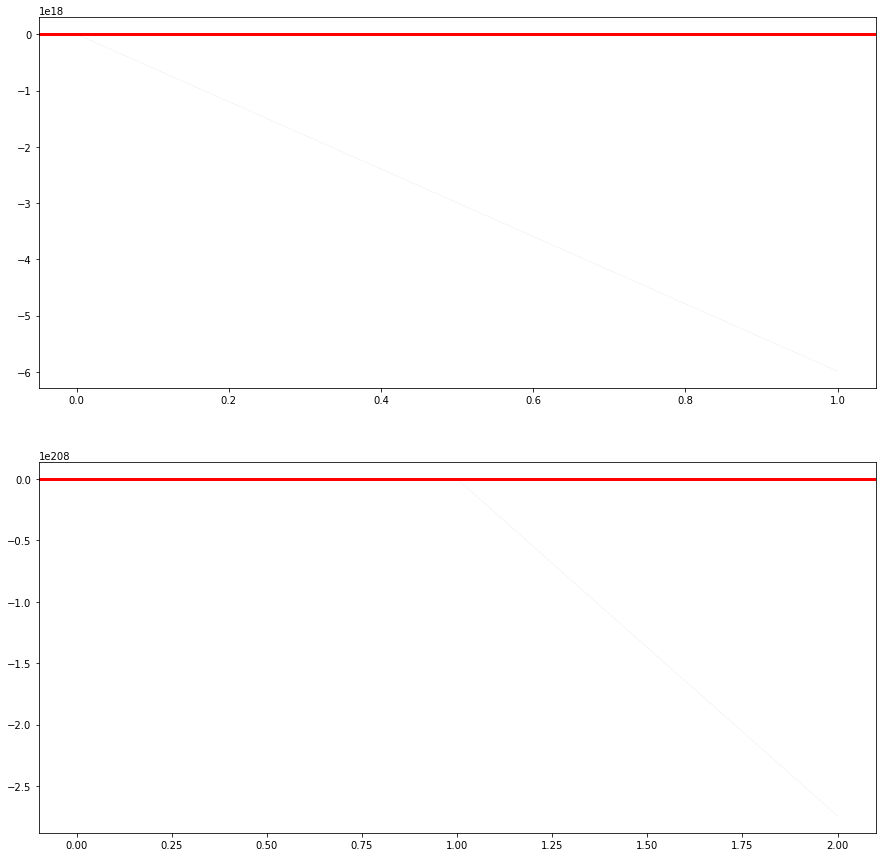

In [365]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax1.plot(tgrid, xr[0], 'r', lw=3)            
# ax2.plot(tgrid, xr[1], 'r', lw=3)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
plt.show()

In [385]:
N_pred = 5

obj = 0

g = []

Q = ca.diag([1,1e5,1,1] )
R = ca.diag([1]* Nu)

x0_SX = ca.SX.sym("x0_SX", Nx)
xr = np.array([[2149.08256708], [1090.29641389],  [114.06152323],  [112.77703172]])
ur = np.array([[14.19],[-1113.5]])


obj = 0

xk_dec_list = []
uk_dec_list = []
for i in range(N_pred):
    xi_var = ca.SX.sym('x_' + str(i + 1), Nx)
    ui_var = ca.SX.sym('u_' + str(i + 1), Nu)
    uk = ui_var
    xk = xi_var
    
    obj +=  (xk-xr).T @ Q @ (xk-xr) + (uk-ur).T @ R @ (uk-ur)
    if i == 0:
        g += [xk - x0_SX]
    else:
        g += [xk - ode_dis_func(xk_pre,uk_pre)]
        
    xk_pre = xk
    uk_pre = uk

    xk_dec_list += [xk]
    uk_dec_list += [uk]
    
xf = ca.SX.sym('x_' + str(N_pred), Nx)
obj += (xf-xr).T @ Q @ (xf-xr)
g += [xf - ode_dis_func(xk_pre,uk_pre)]

xk_dec_list += [xf]

p = [x0_SX]

In [386]:
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*(xk_dec_list+uk_dec_list)),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*p)
}

In [391]:
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [392]:
x_trajectory = []
u_trajectory = []

N_sim = 250

In [393]:
Nx_total

24

In [394]:
x_init = [2149.08256708, 1000.29641389,  114.06152323,  112.77703172]
nl = {}
nl['x0'] = x_init * (N_pred + 1)  + [14.19,-1113.5] * N_pred
nl['lbx'] = [-ca.inf] * Nx * (N_pred + 1) +  [-ca.inf] * Nu * N_pred
nl['ubx'] = [ca.inf] * Nx * (N_pred + 1) +  [ca.inf] * Nu * N_pred
nl['lbg'] = [0] * Nx * (N_pred + 1) 
nl['ubg'] = [0] * Nx * (N_pred + 1) 
# nl['p'] = [x0]

xk = x_init
x_trajectory = []
x_trajectory += xk

Nx_total = Nx * (N_pred + 1)

# Start simulation
for i in range(N_sim):
    print(xk)
    nl['p'] = xk
    sol = solver(**nl)
    sol_opt = sol['x'].full().flatten()

    # Find optimal input
    opt_u = sol_opt[Nx_total : Nx_total + Nu].tolist()
    print(sol_opt)
    u_trajectory += opt_u

    # Apply the optimal input to the real system
    x_next_real = ode_dis_func(xk,opt_u)
    x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

    # Update solver
    xk = x_next_real
    nl['x0'] = sol_opt

#     nl['lbx'][:Nx] = x_next_real.full().flatten().tolist()
#     nl['ubx'][:Nx] = x_next_real.full().flatten().tolist()


[2149.08256708, 1000.29641389, 114.06152323, 112.77703172]
[ 2147.0270819   1000.07757811   114.06547951   112.7816835
  2149.14774203  1000.30040127   114.07592934   112.79367434
  2149.14774204  1000.30040119   114.07592945   112.79367447
  2149.14774204  1000.30040115   114.07592951   112.79367454
  2149.14774203  1000.30040127   114.07592933   112.79367433
  2149.08256708  1000.29641389   114.06152323   112.77703189
    14.1678776  -1113.62834482    14.20759617 -1113.49772968
    14.2075963  -1113.49772968    14.20759637 -1113.49772968
    14.20759616 -1113.49772968]
[-8.71851e+19, -7.25046e+18, 1.33832e+18, -597242]


CasADi - 2022-05-05 13:28:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 4, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:03 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 4, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:05 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 4, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:05 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 8, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:05 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 4, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:05 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 4, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:05 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 4, col 0).")

[ 2192.05404314  1004.44664714   114.39060385   113.15503394
  2149.1696898   1000.31201819   114.07631632   112.79412655
  2149.17012894  1000.31206753   114.07631189   112.7941214
  2149.17012888  1000.31206787   114.07631195   112.79412148
  2149.16968978  1000.31201826   114.07631635   112.79412659
  2149.08256708  1000.29641389   114.06152323   112.77703189
    15.17113563 -1118.75044282    14.20758538 -1113.49756988
    14.20758592 -1113.49755244    14.207586   -1113.49755246
    14.20758542 -1113.49756988]
[-inf, -5.53316e+217, inf, 5.49336e+205]
[ 2192.05404314  1004.44664714   114.39060385   113.15503394
  2149.1696898   1000.31201819   114.07631632   112.79412655
  2149.17012894  1000.31206753   114.07631189   112.7941214
  2149.17012888  1000.31206787   114.07631195   112.79412148
  2149.16968978  1000.31201826   114.07631635   112.79412659
  2149.08256708  1000.29641389   114.06152323   112.77703189
    15.17113563 -1118.75044282    14.20758538 -1113.49756988
    14.2075859

2022-05-05 13:28:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:07 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../cas

[ 2192.05404314  1004.44664714   114.39060385   113.15503394
  2149.1696898   1000.31201819   114.07631632   112.79412655
  2149.17012894  1000.31206753   114.07631189   112.7941214
  2149.17012888  1000.31206787   114.07631195   112.79412148
  2149.16968978  1000.31201826   114.07631635   112.79412659
  2149.08256708  1000.29641389   114.06152323   112.77703189
    15.17113563 -1118.75044282    14.20758538 -1113.49756988
    14.20758592 -1113.49755244    14.207586   -1113.49755246
    14.20758542 -1113.49756988]
[nan, nan, nan, nan]
[ 2192.05404314  1004.44664714   114.39060385   113.15503394
  2149.1696898   1000.31201819   114.07631632   112.79412655
  2149.17012894  1000.31206753   114.07631189   112.7941214
  2149.17012888  1000.31206787   114.07631195   112.79412148
  2149.16968978  1000.31201826   114.07631635   112.79412659
  2149.08256708  1000.29641389   114.06152323   112.77703189
    15.17113563 -1118.75044282    14.20758538 -1113.49756988
    14.20758592 -1113.49755244    

[nan, nan, nan, nan]
[ 2192.05404314  1004.44664714   114.39060385   113.15503394
  2149.1696898   1000.31201819   114.07631632   112.79412655
  2149.17012894  1000.31206753   114.07631189   112.7941214
  2149.17012888  1000.31206787   114.07631195   112.79412148
  2149.16968978  1000.31201826   114.07631635   112.79412659
  2149.08256708  1000.29641389   114.06152323   112.77703189
    15.17113563 -1118.75044282    14.20758538 -1113.49756988
    14.20758592 -1113.49755244    14.207586   -1113.49755246
    14.20758542 -1113.49756988]
[nan, nan, nan, nan]
[ 2192.05404314  1004.44664714   114.39060385   113.15503394
  2149.1696898   1000.31201819   114.07631632   112.79412655
  2149.17012894  1000.31206753   114.07631189   112.7941214
  2149.17012888  1000.31206787   114.07631195   112.79412148
  2149.16968978  1000.31201826   114.07631635   112.79412659
  2149.08256708  1000.29641389   114.06152323   112.77703189
    15.17113563 -1118.75044282    14.20758538 -1113.49756988
    14.207585

2022-05-05 13:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-05-05 13:28:08 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../cas

#### Model 4

from "Gain-scheduling trajectory control of a
continuous stirred tank reactor"

In [515]:
def CSTR_model4(x, u):
    '''
    state = [cA, cB, theta, theta_K]
    
    input = [V_dot/VR, QK_dot]
    
    ki(theta) = ki0 * exp(Ei / (theta + 273.15))
    '''

    k10 = 1.287e12
    k20 = 1.287e12
    k30 = 9.043e9

    E1 = -9758.3
    E2 = -9758.3
    E3 = -8560
    Delta_H_RAB = 4.2
    Delta_H_RBC = -11.0
    Delta_H_RAD = -41.85

    rho = 0.9342

    Cp = 3.01
    kw = 4032

    AR = 0.215
    VR = 10.01
    mK = 5.0
    CPK = 2.0

    cA0 = 5.10
    theta0 = 130.0


    cA = x[0]
    cB = x[1]
    theta = x[2]
    theta_K = x[3]

    k1 = k10 * ca.exp(E1 / (theta + 273.15))
    k2 = k20 * ca.exp(E2 / (theta + 273.15))
    k3 = k30 * ca.exp(E3 / (theta + 273.15))


    x1p = u[0] * (cA0 - cA) - k1 * cA - k3 * cA**2
    x2p = -u[0] * cB + k1 * cA - k2 * cB
    x3p = u[0] * (theta0 - theta) - 1/(rho * Cp) * (k1 * cA * Delta_H_RAB + k2 * cB * Delta_H_RBC + k3 * cA **2 * Delta_H_RAD) + (kw * AR) / (rho * Cp * VR) * (theta_K - theta)
    x4p = 1/(mK * CPK) * (u[1] + kw * AR * (theta - theta_K)) 
    
    rhs = [x1p,
           x2p,
           x3p,
           x4p
           ]

    return ca.vertcat(*rhs)

In [557]:
Nx = 4
Nu = 2


x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
# theta_SX = ca.SX.sym("theta_SX", N_theta)
# t_SX = ca.SX.sym("t", 1)

delta_t = 0.01

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_model4(x_SX, u_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX], [ode_dis_SX])

In [558]:
xs = [1.235, 0.9, 134.14, 128.95]
us = [18.83, -4495.7]

In [559]:
ode(xs,us)

DM([-0.0134414, 0.00888231, 0.0693605, 0.34072])

In [584]:
dt_sys = ode_dis_func(x_SX, u_SX)
A = ca.jacobian(dt_sys, x_SX)
B = ca.jacobian(dt_sys, u_SX)

A_fn = ca.Function("A_fn", [x_SX, u_SX], [A])
B_fn = ca.Function("B_fn", [x_SX, u_SX], [B])

In [585]:
Q = ca.diag([1,10,1,1] )
R = ca.diag([1]* Nu)

A_np = A_fn(xs,us).full()
B_np = B_fn(xs,us).full()

K_np = np.array(dlqr(A_np,B_np,Q,R))

[[47.90027966 37.79576371 12.26879829  5.16022714]
 [37.79576371 41.89764307  9.99269344  4.21754866]
 [12.26879829  9.99269344  4.85370098  1.6733735 ]
 [ 5.16022714  4.21754866  1.6733735   1.84838926]]


In [586]:
K_np

array([[-0.90022813, -0.67939398, -0.19129744, -0.08066507],
       [-0.00551727, -0.0045146 , -0.00181902, -0.00098111]])

In [561]:
N_pred = 5

obj = 0

g = []

Q = ca.diag([1,10,1,1] )
R = ca.diag([1]* Nu)

x0_SX = ca.SX.sym("x0_SX", Nx)
xr = np.array([[1.235], [0.9],  [134.14],  [128.95]])
ur = np.array([[18.83],[-4495.7]])


obj = 0

xk_dec_list = []
uk_dec_list = []
for i in range(N_pred):
    xi_var = ca.SX.sym('x_' + str(i + 1), Nx)
    ui_var = ca.SX.sym('u_' + str(i + 1), Nu)
    uk = ui_var
    xk = xi_var
    
    obj +=  (xk-xr).T @ Q @ (xk-xr) + (uk-ur).T @ R @ (uk-ur)
    if i == 0:
        g += [xk - x0_SX]
    else:
        g += [xk - ode_dis_func(xk_pre,uk_pre)]
        
    xk_pre = xk
    uk_pre = uk

    xk_dec_list += [xk]
    uk_dec_list += [uk]
    
xf = ca.SX.sym('x_' + str(N_pred), Nx)
obj += (xf-xr).T @ Q @ (xf-xr)
g += [xf - ode_dis_func(xk_pre,uk_pre)]

xk_dec_list += [xf]

p = [x0_SX]

In [562]:
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*(xk_dec_list+uk_dec_list)),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*p)
}

In [563]:
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [568]:
x_trajectory = []
u_trajectory = []

N_sim = 150

In [581]:
x_init = [1.235, 1.0, 134.14, 128.95]
nl = {}
nl['x0'] = x_init * (N_pred + 1)  + us * N_pred
nl['lbx'] = [1.233, -ca.inf, -ca.inf, -ca.inf] * (N_pred + 1) +  [-ca.inf] * Nu * N_pred
# nl['ubx'] = [ca.inf, ca.inf, ca.inf, 129.05]  * (N_pred + 1) +  [ca.inf] * Nu * N_pred
nl['ubx'] = [ca.inf, ca.inf, ca.inf, ca.inf]  * (N_pred + 1) +  [ca.inf] * Nu * N_pred
nl['lbg'] = [0] * Nx * (N_pred + 1) 
nl['ubg'] = [0] * Nx * (N_pred + 1) 
# nl['p'] = [x0]

xk = x_init
x_trajectory = []
x_trajectory += xk

Nx_total = Nx * (N_pred + 1)

# Start simulation
for i in range(N_sim):
    print(xk)
    nl['p'] = xk
    sol = solver(**nl)
    sol_opt = sol['x'].full().flatten()

    # Find optimal input
    opt_u = sol_opt[Nx_total : Nx_total + Nu].tolist()
    print(sol_opt)
    u_trajectory += opt_u

    # Apply the optimal input to the real system
    x_next_real = ode_dis_func(xk,opt_u)
    x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

    # Update solver
    xk = x_next_real
    nl['x0'] = sol_opt

#     nl['lbx'][:Nx] = x_next_real.full().flatten().tolist()
#     nl['ubx'][:Nx] = x_next_real.full().flatten().tolist()


[1.235, 1.0, 134.14, 128.95]
[ 1.23500000e+00  1.00000000e+00  1.34140000e+02  1.28950000e+02
  1.23300000e+00  9.50332003e-01  1.34259959e+02  1.29002816e+02
  1.23299999e+00  9.24782238e-01  1.34296561e+02  1.29059729e+02
  1.23299999e+00  9.11976606e-01  1.34303108e+02  1.29092552e+02
  1.23299999e+00  9.05576516e-01  1.34298326e+02  1.29105593e+02
  1.23299999e+00  9.02381559e-01  1.34289394e+02  1.29106653e+02
  1.88514704e+01 -4.49570045e+03  1.89499824e+01 -4.49570042e+03
  1.89665068e+01 -4.49570034e+03  1.89648476e+01 -4.49570024e+03
  1.89563563e+01 -4.49570013e+03]
[1.233, 0.950332, 134.26, 129.003]
[ 1.23300000e+00  9.50332003e-01  1.34259959e+02  1.29002816e+02
  1.23299999e+00  9.24782238e-01  1.34296561e+02  1.29059729e+02
  1.23299999e+00  9.11976606e-01  1.34303108e+02  1.29092552e+02
  1.23299999e+00  9.05576516e-01  1.34298326e+02  1.29105593e+02
  1.23299999e+00  9.02381559e-01  1.34289394e+02  1.29106653e+02
  1.23299999e+00  9.00787251e-01  1.34279164e+02  1.29101

  1.88303075e+01 -4.49570001e+03]
[1.234, 0.89957, 134.153, 128.969]
[ 1.23400361e+00  8.99569697e-01  1.34153466e+02  1.28968756e+02
  1.23406163e+00  8.99606391e-01  1.34152600e+02  1.28967673e+02
  1.23413468e+00  8.99637453e-01  1.34151861e+02  1.28966757e+02
  1.23420680e+00  8.99669223e-01  1.34151261e+02  1.28965989e+02
  1.23426769e+00  8.99701269e-01  1.34150794e+02  1.28965364e+02
  1.23430931e+00  8.99731073e-01  1.34150446e+02  1.28964872e+02
  1.88276246e+01 -4.49570004e+03  1.88286363e+01 -4.49570003e+03
  1.88295113e+01 -4.49570003e+03  1.88301162e+01 -4.49570002e+03
  1.88302960e+01 -4.49570001e+03]
[1.23406, 0.899606, 134.153, 128.968]
[ 1.23406163e+00  8.99606391e-01  1.34152600e+02  1.28967673e+02
  1.23411035e+00  8.99637762e-01  1.34151875e+02  1.28966764e+02
  1.23417486e+00  8.99664085e-01  1.34151255e+02  1.28965995e+02
  1.23423956e+00  8.99691569e-01  1.34150754e+02  1.28965352e+02
  1.23429432e+00  8.99719808e-01  1.34150370e+02  1.28964831e+02
  1.23433116e+

  1.88302380e+01 -4.49570001e+03]
[1.23436, 0.899802, 134.148, 128.962]
[ 1.23435868e+00  8.99802482e-01  1.34148201e+02  1.28962132e+02
  1.23435872e+00  8.99802506e-01  1.34148200e+02  1.28962131e+02
  1.23437906e+00  8.99802266e-01  1.34148188e+02  1.28962125e+02
  1.23440574e+00  8.99806568e-01  1.34148192e+02  1.28962119e+02
  1.23442923e+00  8.99814675e-01  1.34148225e+02  1.28962129e+02
  1.23444175e+00  8.99824085e-01  1.34148288e+02  1.28962164e+02
  1.88281186e+01 -4.49570003e+03  1.88288952e+01 -4.49570003e+03
  1.88295897e+01 -4.49570002e+03  1.88300835e+01 -4.49570002e+03
  1.88302380e+01 -4.49570001e+03]
[1.23436, 0.899803, 134.148, 128.962]
[ 1.23435872e+00  8.99802506e-01  1.34148200e+02  1.28962131e+02
  1.23435875e+00  8.99802526e-01  1.34148200e+02  1.28962131e+02
  1.23437908e+00  8.99802283e-01  1.34148188e+02  1.28962124e+02
  1.23440576e+00  8.99806582e-01  1.34148192e+02  1.28962119e+02
  1.23442925e+00  8.99814687e-01  1.34148225e+02  1.28962129e+02
  1.2344417

  1.88302380e+01 -4.49570001e+03]
[1.23436, 0.899803, 134.148, 128.962]
[ 1.23435890e+00  8.99802627e-01  1.34148198e+02  1.28962128e+02
  1.23435890e+00  8.99802627e-01  1.34148198e+02  1.28962128e+02
  1.23437921e+00  8.99802367e-01  1.34148186e+02  1.28962122e+02
  1.23440586e+00  8.99806652e-01  1.34148190e+02  1.28962117e+02
  1.23442933e+00  8.99814744e-01  1.34148224e+02  1.28962127e+02
  1.23444183e+00  8.99824141e-01  1.34148287e+02  1.28962162e+02
  1.88281189e+01 -4.49570003e+03  1.88288954e+01 -4.49570003e+03
  1.88295897e+01 -4.49570002e+03  1.88300835e+01 -4.49570002e+03
  1.88302380e+01 -4.49570001e+03]
[1.23436, 0.899803, 134.148, 128.962]
[ 1.23435890e+00  8.99802627e-01  1.34148198e+02  1.28962128e+02
  1.23435890e+00  8.99802627e-01  1.34148198e+02  1.28962128e+02
  1.23437921e+00  8.99802368e-01  1.34148186e+02  1.28962122e+02
  1.23440586e+00  8.99806652e-01  1.34148190e+02  1.28962117e+02
  1.23442933e+00  8.99814744e-01  1.34148224e+02  1.28962127e+02
  1.2344418

  1.88302380e+01 -4.49570001e+03]
[1.23436, 0.899803, 134.148, 128.962]
[ 1.23435890e+00  8.99802628e-01  1.34148198e+02  1.28962128e+02
  1.23435890e+00  8.99802628e-01  1.34148198e+02  1.28962128e+02
  1.23437921e+00  8.99802368e-01  1.34148186e+02  1.28962122e+02
  1.23440586e+00  8.99806653e-01  1.34148190e+02  1.28962117e+02
  1.23442933e+00  8.99814745e-01  1.34148224e+02  1.28962127e+02
  1.23444183e+00  8.99824141e-01  1.34148287e+02  1.28962162e+02
  1.88281189e+01 -4.49570003e+03  1.88288954e+01 -4.49570003e+03
  1.88295897e+01 -4.49570002e+03  1.88300835e+01 -4.49570002e+03
  1.88302380e+01 -4.49570001e+03]
[1.23436, 0.899803, 134.148, 128.962]
[ 1.23435890e+00  8.99802628e-01  1.34148198e+02  1.28962128e+02
  1.23435890e+00  8.99802628e-01  1.34148198e+02  1.28962128e+02
  1.23437921e+00  8.99802368e-01  1.34148186e+02  1.28962122e+02
  1.23440586e+00  8.99806653e-01  1.34148190e+02  1.28962117e+02
  1.23442933e+00  8.99814745e-01  1.34148224e+02  1.28962127e+02
  1.2344418

In [582]:
len(traj_list[0])

504

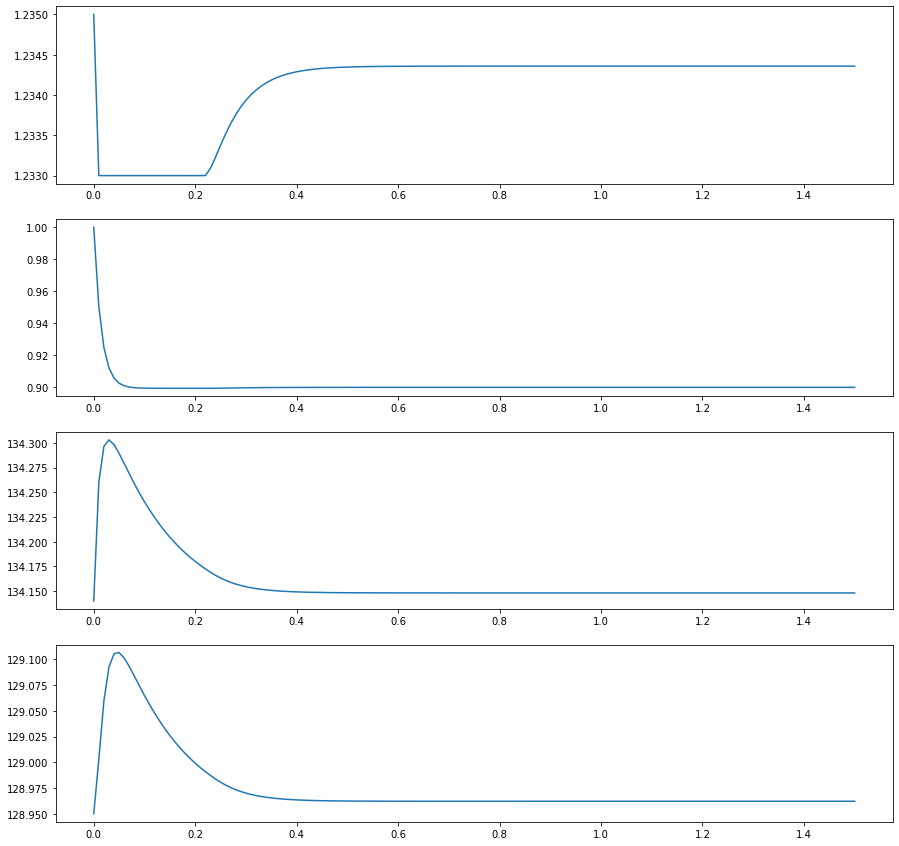

In [583]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2, ax3, ax4] = plt.subplots(4,1,figsize=(15,15))




for j in range (Nx):
    x_opt = x_trajectory[j::Nx]
    if j == 0:
        ax1.plot(tgrid, x_opt)
    elif j == 1:
        ax2.plot(tgrid, x_opt)
    elif j == 2:
        ax3.plot(tgrid, x_opt)
    else:
        ax4.plot(tgrid, x_opt)

# ax1.plot(tgrid, xr[0], 'r', lw=3)            
# ax2.plot(tgrid, xr[1], 'r', lw=3)
# ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
# ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
plt.show()

In [587]:
Q = ca.diag([1,10,1,1] )
R = ca.diag([1]* Nu)

A_np = A_fn(xs,us).full()
B_np = B_fn(xs,us).full()

K_np = np.array(dlqr(A_np,B_np,Q,R))

[[47.90027966 37.79576371 12.26879829  5.16022714]
 [37.79576371 41.89764307  9.99269344  4.21754866]
 [12.26879829  9.99269344  4.85370098  1.6733735 ]
 [ 5.16022714  4.21754866  1.6733735   1.84838926]]


In [591]:
N_traj = 1
x_init = [1.235, 1.0, 134.14, 128.95]

xr = np.array([[1.235], [0.9],  [134.14],  [128.95]])
ur = np.array([[18.83],[-4495.7]])
N_sim = 150
uk = 0



traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    uk_p = np.array([[0]])
    for j in range(N_sim):
        uk = K_np @ (xk - xr) + ur
        uk_p = uk
        xk_p1 = ode_dis_func(xk,uk)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]
    print('{number} is done'.format(number = i))

0 is done


In [594]:
len(traj_list[0])

604

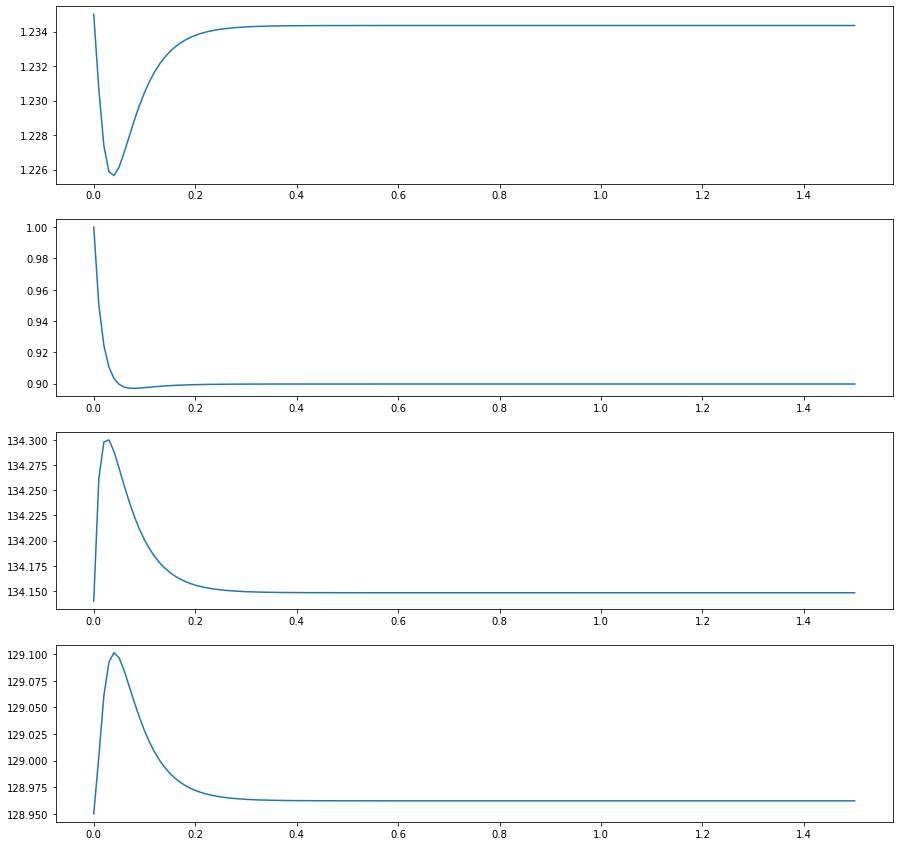

In [595]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2, ax3, ax4] = plt.subplots(4,1,figsize=(15,15))


for j in range (Nx):
    x_opt = traj_list[0][j::Nx]
    if j == 0:
        ax1.plot(tgrid, x_opt)
    elif j == 1:
        ax2.plot(tgrid, x_opt)
    elif j == 2:
        ax3.plot(tgrid, x_opt)
    else:
        ax4.plot(tgrid, x_opt)

# ax1.plot(tgrid, xr[0], 'r', lw=3)            
# ax2.plot(tgrid, xr[1], 'r', lw=3)
# ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
# ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
plt.show()

### Under disturbance

In [600]:
def integrator_rk4(f, x, u, p, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u, p)
        k2 = f(x + delta_t / 2 * k1, u, p)
        k3 = f(x + delta_t / 2 * k2, u, p)
        k4 = f(x + delta_t * k3, u, p)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next

In [601]:
def CSTR_model5(x, u, p):
    '''
    state = [cA, cB, theta, theta_K]
    
    input = [V_dot/VR, QK_dot]
    
    ki(theta) = ki0 * exp(Ei / (theta + 273.15))
    '''

    k10 = 1.287e12
    k20 = 1.287e12
    k30 = 9.043e9

    E1 = -9758.3
    E2 = -9758.3
    E3 = -8560
    Delta_H_RAB = 4.2
    Delta_H_RBC = -11.0
    Delta_H_RAD = -41.85

    rho = 0.9342

    Cp = 3.01
    kw = 4032

    AR = 0.215
    VR = 10.01
    mK = 5.0
    CPK = 2.0

    cA0 = 5.10
    theta0 = 130.0


    cA = x[0]
    cB = x[1]
    theta = x[2]
    theta_K = x[3]

    k1 = k10 * ca.exp(E1 / (theta + 273.15))
    k2 = k20 * ca.exp(E2 / (theta + 273.15))
    k3 = k30 * ca.exp(E3 / (theta + 273.15))


    x1p = u[0] * (cA0 - cA) - k1 * cA - k3 * cA**2 + p[0]
    x2p = -u[0] * cB + k1 * cA - k2 * cB 
    x3p = u[0] * (theta0 - theta) - 1/(rho * Cp) * (k1 * cA * Delta_H_RAB + k2 * cB * Delta_H_RBC + k3 * cA **2 * Delta_H_RAD) + (kw * AR) / (rho * Cp * VR) * (theta_K - theta) + p[1]
    x4p = 1/(mK * CPK) * (u[1] + kw * AR * (theta - theta_K)) 
    
    rhs = [x1p,
           x2p,
           x3p,
           x4p
           ]

    return ca.vertcat(*rhs)

In [607]:
Nx = 4
Nu = 2
N_theta = 2

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)
theta_SX = ca.SX.sym("theta_SX", N_theta)

delta_t = 0.01

ode = ca.Function("ode_func", [x_SX, u_SX, theta_SX], [CSTR_model5(x_SX, u_SX, theta_SX)])
ode_dis_SX = integrator_rk4(ode, x_SX, u_SX, theta_SX, delta_t)

ode_dis_func = ca.Function("ode_dis", [x_SX, u_SX, theta_SX], [ode_dis_SX])

In [609]:
dt_sys = ode_dis_func(x_SX, u_SX, theta_SX)
A = ca.jacobian(dt_sys, x_SX)
B = ca.jacobian(dt_sys, u_SX)

A_fn = ca.Function("A_fn", [x_SX, u_SX, theta_SX], [A])
B_fn = ca.Function("B_fn", [x_SX, u_SX, theta_SX], [B])

In [622]:
xs = [1.235, 0.9, 134.14, 128.95]
us = [18.83, -4495.7]

#### Setting 1
Q = ca.diag([1,1,1,1] )
R = ca.diag([1]* Nu)

In [625]:
Q = ca.diag([1,1,1,1] )
R = ca.diag([1]* Nu)

A_np = A_fn(xs,us, [0,0]).full()
B_np = B_fn(xs,us, [0,0]).full()

K_np = np.array(dlqr(A_np,B_np,Q,R))

[[46.82375953 36.11995597 12.28400148  5.1584965 ]
 [36.11995597 29.91302987 10.00708916  4.21392706]
 [12.28400148 10.00708916  4.84339759  1.66984837]
 [ 5.1584965   4.21392706  1.66984837  1.8471211 ]]


In [626]:
N_sim = 1000
N_traj = 500
x_init = [1.235, 1.0, 134.14, 128.95]

xr = np.array([[1.235], [0.9],  [134.14],  [128.95]])
ur = np.array([[18.83],[-4495.7]])

theta_dist = 0.1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,2)
        uk = K_np @ (xk - xr) + ur
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]

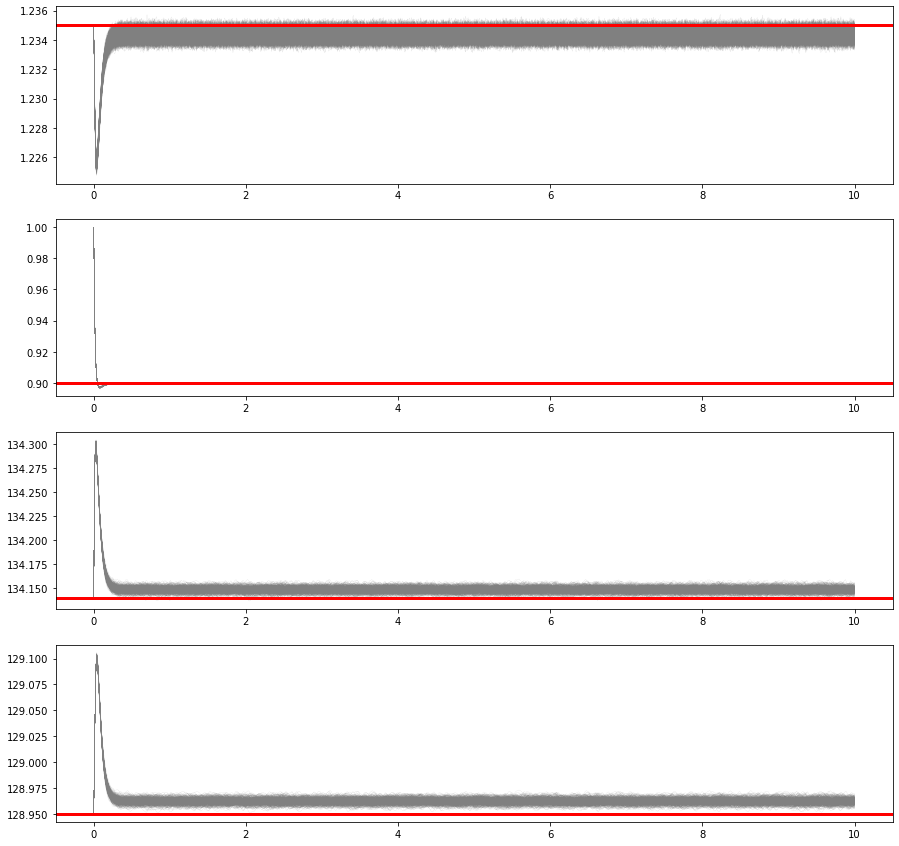

In [627]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2, ax3, ax4] = plt.subplots(4,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        elif j == 1:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        elif j == 2:
            ax3.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax4.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax1.plot(tgrid, xr[0], 'r', lw=3)            
# ax2.plot(tgrid, xr[1], 'r', lw=3)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
ax3.axhline(xr[2], color='r', linestyle='-', lw=3)
ax4.axhline(xr[3], color='r', linestyle='-', lw=3)
plt.show()

#### Setting 2
Q = ca.diag([1,1,1,1] )
R = ca.diag([1]* Nu)

In [636]:
Q = ca.diag([1,1,10,10] )
R = ca.diag([0.1]* Nu)

A_np = A_fn(xs,us, [0,0]).full()
B_np = B_fn(xs,us, [0,0]).full()

K_np = np.array(dlqr(A_np,B_np,Q,R))

[[172.60966844 145.56646969  61.27893867  25.51530023]
 [145.56646969 125.44514138  53.38667204  22.41296974]
 [ 61.27893867  53.38667204  34.88765903  10.9898871 ]
 [ 25.51530023  22.41296974  10.9898871   16.0624235 ]]


In [ ]:
N_sim = 1000
N_traj = 500
x_init = [1.235, 1.0, 134.14, 128.95]

xr = np.array([[1.235], [0.9],  [134.14],  [128.95]])
ur = np.array([[18.83],[-4495.7]])

theta_dist = 0.1
uk = 0

traj_list = []
for i in range(N_traj):
    xk = x_init
    traj_temp_list = []
    traj_temp_list += xk
    xk = np.array(xk).reshape(-1,1)
    for j in range(N_sim):
        theta_k = np.random.uniform(-theta_dist,theta_dist,2)
        uk = K_np @ (xk - xr) + ur
        xk_p1 = ode_dis_func(xk,uk,theta_k)
        traj_temp_list += xk_p1.full().flatten().tolist()
        xk = xk_p1.full()
    traj_list += [traj_temp_list]

In [ ]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

# plt.figure(1, figsize=(10, 20))
# plt.clf()
f, [ax1,ax2, ax3, ax4] = plt.subplots(4,1,figsize=(15,15))



for i in range(len(traj_list)):
    x_trajectory_temp = traj_list[i]
    for j in range (Nx):
        x_opt = x_trajectory_temp[j::Nx]
        if j == 0:
            ax1.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        elif j == 1:
            ax2.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        elif j == 2:
            ax3.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)
        else:
            ax4.plot(tgrid, x_opt, 'grey',alpha=0.7,lw=0.1)

# ax1.plot(tgrid, xr[0], 'r', lw=3)            
# ax2.plot(tgrid, xr[1], 'r', lw=3)
ax1.axhline(xr[0], color='r', linestyle='-', lw=3)
ax2.axhline(xr[1], color='r', linestyle='-', lw=3)
ax3.axhline(xr[2], color='r', linestyle='-', lw=3)
ax4.axhline(xr[3], color='r', linestyle='-', lw=3)
plt.show()